In [43]:
import numpy as np
import matplotlib as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

In [67]:
class explorationOptimizer:
    def getEpsilon(epsilon_initial=0.85, epsilon_final=0.05, current_epoch=0, num_epochs=1000):
        return epsilon_initial - (epsilon_initial - epsilon_final) * (current_epoch / num_epochs)

In [37]:
class Agent:
    def __init__(self, k=3, num_epochs=100, num_iters=10000, explorationOptimizer=explorationOptimizer, epsilon_initial=0.85, epsilon_final=0.05):
        self.k = k # Number of arms
        self.num_epochs = num_epochs # Number of times to run
        self.num_iters = num_iters # Number of times to select a value before updating the policy
        self.bandits = np.random.rand(k) # Probability of success for each arm, sample from a gaussian distribution centered around the mean
#         self.bandits = np.array([0.10, 0.12, 0.11, 0.13, 0.14, 0.11, 0.12, 0.09, 0.13, 0.10])
        # self.bandits = np.array([0.10, 0.50, 0.60, 0.80, 0.10, 0.25, 0.60, 0.45, 0.75, 0.65])
        self.explorationOptimizer = explorationOptimizer
        self.epsilon_initial = epsilon_initial
        self.epsilon_final = epsilon_final
        self.Q = [(1, self.get_reward(i)) for i in range(k)]
        self.avg_step_rewards = []
        self.bandit_selections = []
        
    def get_reward(self, selection_idx):
        return int(np.random.uniform() <= self.bandits[selection_idx])
    
    def take_step(self, curr_epoch):
        thresholds = np.random.uniform(size=(self.num_iters))
        greedy = (np.random.uniform(size=(self.num_iters)) >= self.explorationOptimizer.getEpsilon(self.epsilon_initial, self.epsilon_final, curr_epoch, self.num_epochs)).astype(bool)
        avg_max_arm = 0
        max_arm_idx = 0
        
        avg_rewards = [np.average(i[1]) for i in self.Q]
        max_arm_idx = np.argmax(avg_rewards)

        # step_rewards = []
        
        # for i in range(self.num_iters):
        #     if (greedy[i]):
        #         step_rewards.append((max_arm_idx, self.get_reward(max_arm_idx)))
        #     else:
        #         arm_idx = np.random.randint(0, self.k)
        #         step_rewards.append((arm_idx, self.get_reward(arm_idx)))

        # for reward in step_rewards:
        #     # Incremental update
        #     self.Q[reward[0]] = (self.Q[reward[0]][0] + 1, self.Q[reward[0]][1] + 1 / self.Q[reward[0]][0] * (reward[1] - self.Q[reward[0]][1]))
        
        # return np.average([r[1] for r in step_rewards])

        step_rewards = []
        epoch_bandit_selections = {i: 0 for i in range(self.k)}
        arm_idx = 0

        for i in range(self.num_iters):
            avg_rewards = [np.average(i[1]) for i in self.Q]
            
            if (greedy[i]):
                arm_idx = np.argmax(avg_rewards)
                reward = (arm_idx, self.get_reward(arm_idx))
            else:
                arm_idx = np.random.randint(0, self.k)
                reward = (arm_idx, self.get_reward(arm_idx))
            
            epoch_bandit_selections[arm_idx] += 1
            
            self.Q[reward[0]] = (self.Q[reward[0]][0] + 1, self.Q[reward[0]][1] + 1 / self.Q[reward[0]][0] * (reward[1] - self.Q[reward[0]][1]))

            step_rewards.append(reward)
        
        self.bandit_selections.append(epoch_bandit_selections)
        
        return np.average([r[1] for r in step_rewards])

    
    def run(self):
        for epoch in tqdm(range(self.num_epochs)):
            self.avg_step_rewards.append(self.take_step(epoch))
        
        max_idx = np.argmax([r[0] for r in self.Q])
        print(self.Q[max_idx][1])
        print("Max val ", self.Q[max_idx][1] ," at idx ", max_idx)

In [59]:
a = Agent(k=10, num_epochs=100, num_iters=100, explorationOptimizer=explorationOptimizer)
max_mean_idx = np.argmax(a.bandits)
print(a.bandits)
print("Max val ", a.bandits[max_mean_idx] ," at idx ", max_mean_idx)
print(a.explorationOptimizer.getEpsilon())

[0.80183574 0.58090809 0.05621062 0.17926702 0.50208194 0.44678276
 0.91507941 0.90470899 0.55679076 0.36101579]
Max val  0.9150794112464682  at idx  6
0.85


In [60]:
a.run()

100%|██████████| 100/100 [00:01<00:00, 92.01it/s]

0.9110434635548772
Max val  0.9110434635548772  at idx  6


In [61]:
print([r[0] for r in a.Q])
print([r[1] for r in a.Q])

[457, 457, 452, 472, 449, 457, 5914, 478, 429, 445]
[0.8048245614035091, 0.5811403508771934, 0.057649667405764986, 0.18895966029723993, 0.5312500000000004, 0.43640350877192974, 0.9110434635548772, 0.9014675052410903, 0.5093457943925234, 0.3175675675675675]


<AxesSubplot:>

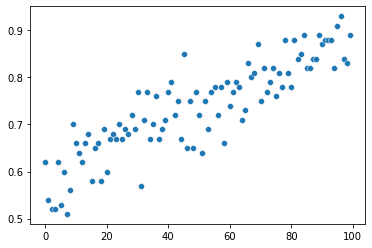

In [62]:
sns.scatterplot(x=[i for i in range(len(a.avg_step_rewards))], y=a.avg_step_rewards)

In [63]:
bandits = pd.DataFrame(a.bandit_selections) # Get arms selected at each epoch
bandits = bandits.div(bandits.sum(axis=1), axis=0) # Get pct of times each bandit arm was selected
bandits

,0,1,2,3,4,5,6,7,8,9
0,0.15,0.09,0.06,0.11,0.08,0.07,0.19,0.09,0.05,0.11
1,0.09,0.09,0.05,0.13,0.08,0.05,0.26,0.07,0.08,0.10
2,0.06,0.08,0.14,0.12,0.07,0.07,0.28,0.07,0.04,0.07
3,0.04,0.09,0.10,0.10,0.02,0.12,0.27,0.09,0.09,0.08
4,0.10,0.06,0.10,0.09,0.08,0.06,0.30,0.07,0.06,0.08
...,...,...,...,...,...,...,...,...,...,...
95,0.02,0.00,0.01,0.02,0.01,0.01,0.91,0.01,0.00,0.01
96,0.01,0.01,0.00,0.01,0.01,0.02,0.91,0.00,0.00,0.03
97,0.01,0.01,0.01,0.01,0.01,0.01,0.91,0.00,0.02,0.01
98,0.00,0.00,0.02,0.00,0.00,0.03,0.92,0.00,0.01,0.02


In [64]:
bandits.iloc[:, 0]

0     0.15
1     0.09
2     0.06
3     0.04
4     0.10
      ... 
95    0.02
96    0.01
97    0.01
98    0.00
99    0.00
Name: 0, Length: 100, dtype: float64

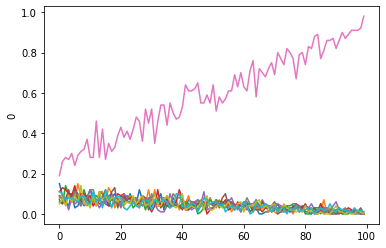

In [66]:
for bandit in range(len(bandits.columns)):
    sns.lineplot(x=[epoch for epoch in range(len(bandits))], y=bandits.iloc[:, bandit])